In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib as jb
%matplotlib inline

import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
import warnings
warnings.filterwarnings('ignore')

In [8]:
df = pd.DataFrame(jb.load('01AEDAdataV1.bin'))

# Análisis de datos

In [9]:
fig = px.histogram(df[['age','gender','hospital_death']].dropna(), x="age",  color="gender",
                   marginal="box", # or violin, rug
                   orientation='v',  # Set orientation to vertical
                   opacity=0.75,
                   hover_data=df[['age','gender','hospital_death']].columns)

# Update layout
fig.update_layout(
    title='Distribución de la edad por género y muerte en el hospital',
    xaxis_title='Edad',
    yaxis_title='Cantdad de muertes en el hospital',
    legend_title='Género',
    template='plotly_white',  # Clean and minimal template
    font=dict(
        family="Arial, sans-serif",
        size=12,
        color="RebeccaPurple"
    )
)

fig.show()

In [10]:
age_death_F=df[df['gender']=='F'][['age','hospital_death']].groupby('age').mean().reset_index()
age_death_M=df[df['gender']=='M'][['age','hospital_death']].groupby('age').mean().reset_index()
from plotly.subplots import make_subplots
fig = make_subplots()
fig.add_trace(
    go.Scatter(x=age_death_F['age'], y=age_death_F['hospital_death'], name="Femenino"))
fig.add_trace(
    go.Scatter(x=age_death_M['age'], y=age_death_M['hospital_death'],name="Masculino"))
fig.update_layout(
    title_text="<b>Probabilidad promedio de muerte hospitalaria de los pacientes<b>")
fig.update_xaxes(title_text="<b>Edad<b>")
fig.update_yaxes(title_text="<b>Promedio de muertes</b>", secondary_y=False)
fig.show()

In [11]:
weight_df=df[['weight','hospital_death','bmi']]
weight_df['weight']=weight_df['weight'].round(0)
weight_df['bmi']=weight_df['bmi'].round(0)
weight_death=weight_df[['weight','hospital_death']].groupby('weight').mean().reset_index()
bmi_death=weight_df[['bmi','hospital_death']].groupby('bmi').mean().reset_index()
fig = tls.make_subplots(rows=1, cols=2, shared_yaxes=True)
fig.add_trace(
    go.Scatter(x=weight_death['weight'], y=weight_death['hospital_death'], name="Peso"),
   row=1, col=1
)
fig.add_trace(
    go.Scatter(x=bmi_death['bmi'], y=bmi_death['hospital_death'], name="IMC"),
    row=1, col=2
)
fig.update_layout(
    title_text="<b>Impactos del IMC (BMI) y el peso sobre los pacientes<b>"
)
fig.update_yaxes(title_text="<b>Promedio de muertes")
fig.show()

In [12]:

ICU_type=df[['icu_type','age','hospital_death']]
ICU_type['icu_type']=ICU_type['icu_type'].replace({'CTICU':'CCU-CTICU',
                                              'Cardiac ICU':'CCT-CTICU',
                                              'CTICU':'CCT-CTICU',
                                              'CSICU':'SICU'})
ICU_df=ICU_type.groupby(['icu_type','age']).mean().reset_index()
ICU_df['count']=ICU_type.groupby(['icu_type','age']).count().reset_index()['hospital_death']

fig = px.scatter(ICU_df, x="age", y="hospital_death", size="count", color="icu_type",
           hover_name="icu_type", log_x=False, size_max=60,)
fig.update_layout(
    title_text="<b>Tasa de supervivencia en diferentes tipos de ICU<b>",
    
)
fig.update_yaxes(title_text="<b>Muertes promedio<b>")
fig.update_xaxes(title_text="<b>Edad<b>")
fig.show()

In [13]:
apache3=df[['age','apache_3j_bodysystem','hospital_death']]
apache3=apache3.groupby(['apache_3j_bodysystem','age']).agg(['size','mean']).reset_index()

apache3['size']=apache3['hospital_death']['size']
apache3['mean']=apache3['hospital_death']['mean']

apache3.drop('hospital_death',axis=1,inplace=True)

systems =list(apache3['apache_3j_bodysystem'].unique())
data = []
list_updatemenus = []
for n, s in enumerate(systems):
    visible = [False] * len(systems)
    visible[n] = True
    temp_dict = dict(label = str(s),
                 method = 'update',
                 args = [{'visible': visible},
                         {'title': '<b>'+s+'<b>'}])
    list_updatemenus.append(temp_dict)
    

for s in systems:
    mask = (apache3['apache_3j_bodysystem'].values == s) 
    trace = (dict(visible = False,     
        x = apache3.loc[mask, 'age'],
        y = apache3.loc[mask, 'mean'],
        mode = 'markers',
        marker = {'size':apache3.loc[mask, 'size']/apache3.loc[mask,'size'].sum()*1000,
                 'color':apache3.loc[mask, 'mean'],
                 'showscale': True})
                   )
    data.append(trace)

data[0]['visible'] = True    
    
layout = dict(updatemenus=list([dict(buttons= list_updatemenus)]),
              xaxis=dict(title = '<b>Edad<b>', range=[min(apache3.loc[:, 'age'])-10, max(apache3.loc[:, 'age']) + 10]),
              yaxis=dict(title = '<b>Muertes promedio<b>', range=[min(apache3.loc[:, 'mean'])-0.1, max(apache3.loc[:, 'mean'])+0.1]),
              title='<b> Tasa de supervicencia por edad y condición médica<b>' )
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='update_dropdown')

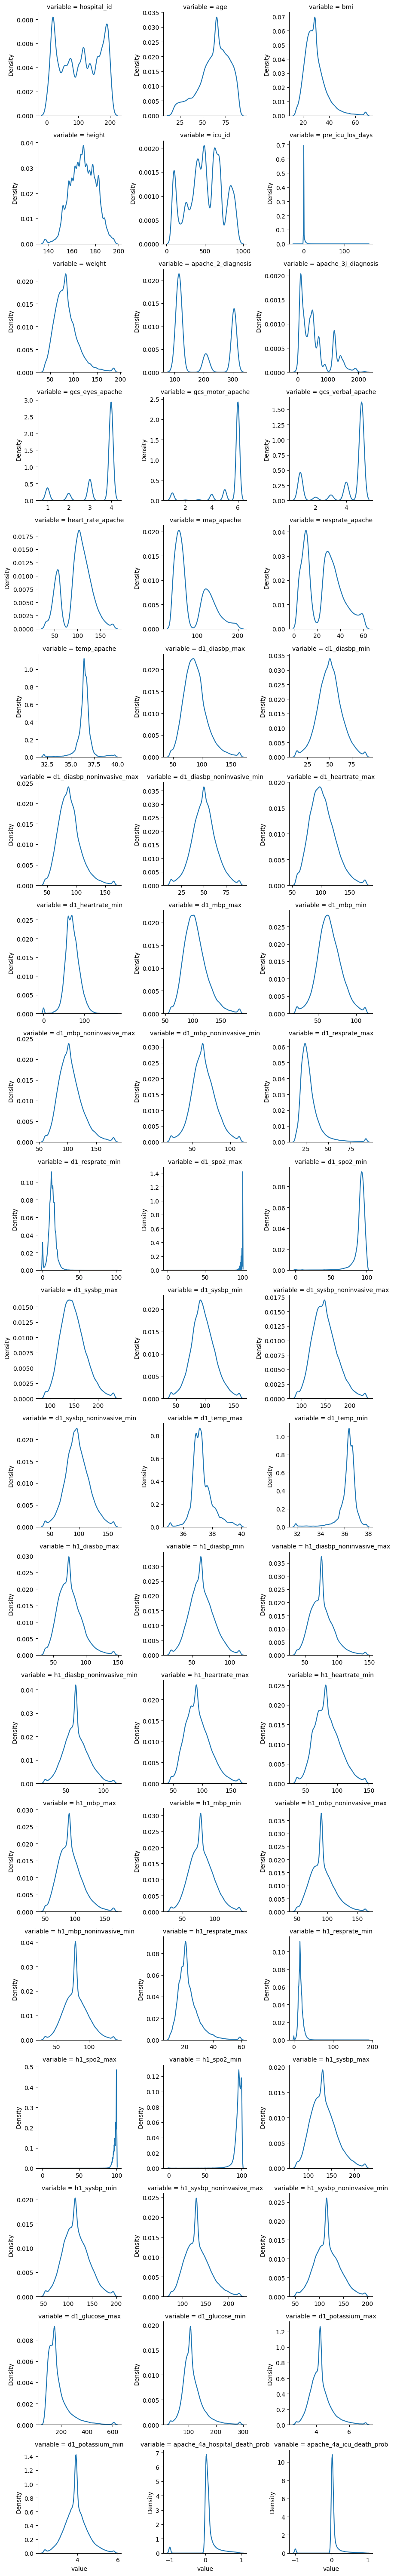

In [14]:
unpivot = pd.melt(df, df.describe().columns[0], df.describe().columns[1:])

g = sns.FacetGrid(unpivot, col="variable", col_wrap=3, sharex=False, sharey=False)
g.map(sns.kdeplot, "value")

plt.show()

In [ ]:

float_columns = df.select_dtypes(include=['float64']).columns.tolist()

#Compute the correlation matrix and apply a threshold
corr = df[float_columns].corr()

# Create the heatmap
fig = ff.create_annotated_heatmap(
    z=corr.values,
    x=list(corr.columns),
    y=list(corr.index),
    annotation_text=corr.round(2).values,
    showscale=True,
    colorscale='Viridis'
)

# Update the layout
fig.update_layout(title='Matriz de correlaciones', width=1000, height=1000)

# Show the plot
fig.show()

# OBSERVACIONES
Vemos que todas las distros de enteros tienen unos picos extraños en la distribución cuando sustituimos los int vacios por la mediana. Esa estrategia parece no ser productiva.